<a href="https://colab.research.google.com/github/nagamharitha/A-real-time-chat-room/blob/main/W3_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
#initialize SparkSession and installed Required Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder \
    .appName("Property_Price_Regression") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()


In [ ]:
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

CPU Usage: 21.2%
Memory Usage: 17.5%


In [ ]:
# Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = spark.read.csv("/content/drive/MyDrive/ML CN7030 /property.csv", header=True, inferSchema=True)

df.show(5)
df.printSchema()


+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
+--------------+------------+-------------+----------+--------+------------------+
only showing top 5 rows

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 

In [ ]:
# show Schema,Prints the structure of the dataset
df.printSchema()

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)



In [ ]:
#Statistical Analysis
df.describe().show()

+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|   Square_Footage|     Num_Bedrooms|     Num_Bathrooms|       Year_Built|         Lot_Size|             Price|
+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|          1000000|          1000000|           1000000|          1000000|          1000000|           1000000|
|   mean|      2750.657104|         3.501114|          2.500439|       1960.52736|      5502.373911| 581839.6653163614|
| stddev|1298.569362387213|1.708173784151257|1.1178528780094728|35.21780350510348|2598.885882999355|260685.36722644986|
|    min|              500|                1|                 1|             1900|             1000| 51495.71116919513|
|    max|             4999|                6|                 4|             2021|             9999|1123219.4691521737|
+-------+-----------------+-------------

In [ ]:
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



In [ ]:
# Define features and target
input_features = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built']
target = 'Price'


In [ ]:
# VectorAssembler
assembler = VectorAssembler(inputCols=input_features, outputCol="features")

In [ ]:

# StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [ ]:
data_train, data_test = df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# Linear Regression
lr = LinearRegression(labelCol=target, featuresCol="scaled_features")
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
model_lr = pipeline_lr.fit(data_train)
pred_lr = model_lr.transform(data_test)

In [ ]:
lasso = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=1.0, regParam=0.1)
pipeline_lasso = Pipeline(stages=[assembler, scaler, lasso])
model_lasso = pipeline_lasso.fit(data_train)
pred_lasso = model_lasso.transform(data_test)

In [ ]:
ridge = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=0.0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, scaler, ridge])
model_ridge = pipeline_ridge.fit(data_train)
pred_ridge = model_ridge.transform(data_test)

In [ ]:
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")

# Linear
r2_lr = evaluator_r2.evaluate(pred_lr)
rmse_lr = evaluator_rmse.evaluate(pred_lr)
mse_lr = evaluator_mse.evaluate(pred_lr)

# Lasso
r2_lasso = evaluator_r2.evaluate(pred_lasso)
rmse_lasso = evaluator_rmse.evaluate(pred_lasso)
mse_lasso = evaluator_mse.evaluate(pred_lasso)

# Ridge
r2_ridge = evaluator_r2.evaluate(pred_ridge)
rmse_ridge = evaluator_rmse.evaluate(pred_ridge)
mse_ridge = evaluator_mse.evaluate(pred_ridge)

# Print
print(f"Linear Regression → R²: {r2_lr}, RMSE: {rmse_lr}, MSE: {mse_lr}")
print(f"Lasso Regression  → R²: {r2_lasso}, RMSE: {rmse_lasso}, MSE: {mse_lasso}")
print(f"Ridge Regression  → R²: {r2_ridge}, RMSE: {rmse_ridge}, MSE: {mse_ridge}")


Linear Regression → R²: 0.9941024406933467, RMSE: 20008.829625707443, MSE: 400353262.99058783
Lasso Regression  → R²: 0.9941024406587798, RMSE: 20008.829684345503, MSE: 400353265.33714575
Ridge Regression  → R²: 0.9941024405879599, RMSE: 20008.82980448194, MSE: 400353270.14472467


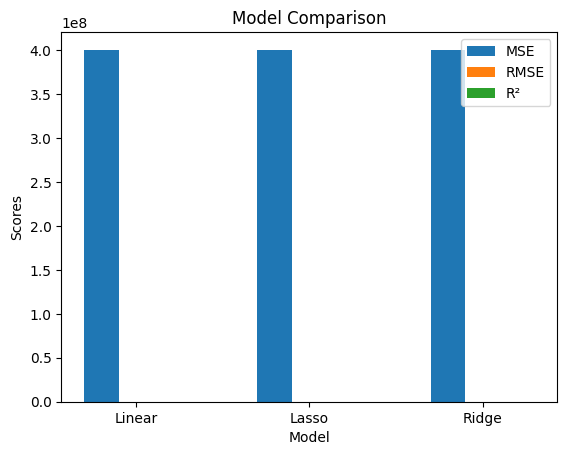

In [ ]:
import itertools
# Store results
models = ['Linear', 'Lasso', 'Ridge']
r2_scores = [r2_lr, r2_lasso, r2_ridge]
rmse_scores = [rmse_lr, rmse_lasso, rmse_ridge]
mse_scores = [mse_lr, mse_lasso, mse_ridge]

x = np.arange(len(models))
width = 0.2

plt.bar(x - width, mse_scores, width, label='MSE')
plt.bar(x, rmse_scores, width, label='RMSE')
plt.bar(x + width, r2_scores, width, label='R²')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()

In [ ]:
input_features = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms']
target = 'Price'


In [ ]:
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [ ]:
data_train, data_test = df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
lr = LinearRegression(labelCol=target, featuresCol="scaled_features")
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
model_lr = pipeline_lr.fit(data_train)
pred_lr = model_lr.transform(data_test)

In [ ]:
lasso = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=1.0, regParam=0.1)
pipeline_lasso = Pipeline(stages=[assembler, scaler, lasso])
model_lasso = pipeline_lasso.fit(data_train)
pred_lasso = model_lasso.transform(data_test)

In [ ]:
ridge = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=0.0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, scaler, ridge])
model_ridge = pipeline_ridge.fit(data_train)
pred_ridge = model_ridge.transform(data_test)

In [ ]:
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")

# Linear
r2_lr = evaluator_r2.evaluate(pred_lr)
rmse_lr = evaluator_rmse.evaluate(pred_lr)
mse_lr = evaluator_mse.evaluate(pred_lr)

# Lasso
r2_lasso = evaluator_r2.evaluate(pred_lasso)
rmse_lasso = evaluator_rmse.evaluate(pred_lasso)
mse_lasso = evaluator_mse.evaluate(pred_lasso)

# Ridge
r2_ridge = evaluator_r2.evaluate(pred_ridge)
rmse_ridge = evaluator_rmse.evaluate(pred_ridge)
mse_ridge = evaluator_mse.evaluate(pred_ridge)

# Print
print(f"Linear Regression → R²: {r2_lr}, RMSE: {rmse_lr}, MSE: {mse_lr}")
print(f"Lasso Regression  → R²: {r2_lasso}, RMSE: {rmse_lasso}, MSE: {mse_lasso}")
print(f"Ridge Regression  → R²: {r2_ridge}, RMSE: {rmse_ridge}, MSE: {mse_ridge}")


Linear Regression → R²: 0.9939189888624038, RMSE: 20317.64777714158, MSE: 412806811.1959862
Lasso Regression  → R²: 0.9939189889132484, RMSE: 20317.647692201535, MSE: 412806807.7444223
Ridge Regression  → R²: 0.9939189888012064, RMSE: 20317.64787937672, MSE: 412806815.35034126


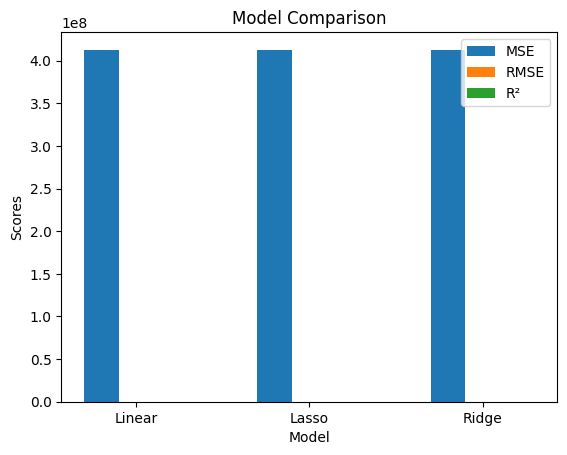

In [ ]:
models = ['Linear', 'Lasso', 'Ridge']
r2_scores = [r2_lr, r2_lasso, r2_ridge]
rmse_scores = [rmse_lr, rmse_lasso, rmse_ridge]
mse_scores = [mse_lr, mse_lasso, mse_ridge]

x = np.arange(len(models))
width = 0.2

plt.bar(x - width, mse_scores, width, label='MSE')
plt.bar(x, rmse_scores, width, label='RMSE')
plt.bar(x + width, r2_scores, width, label='R²')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()
